In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
filename = "Semantic segmentation dataset"


In [3]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Water' : [ 41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60], 
                            'Vegetation' : [ 58, 221, 254],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']
        
    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0] 
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
                angle = np.random.randint(4) * 90
                image = ndimage.rotate(image,angle,reshape=True)
                cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
                image = np.flip(image, 0)
                cls_mask = np.flip(cls_mask, 0)
            
            # horizonal flip
            if np.random.rand()<0.5:
                image = np.flip(image, 1)
                cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512)) 
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [4]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('Semantic segmentation dataset', training = True, transform= t)

len(dataset)

72

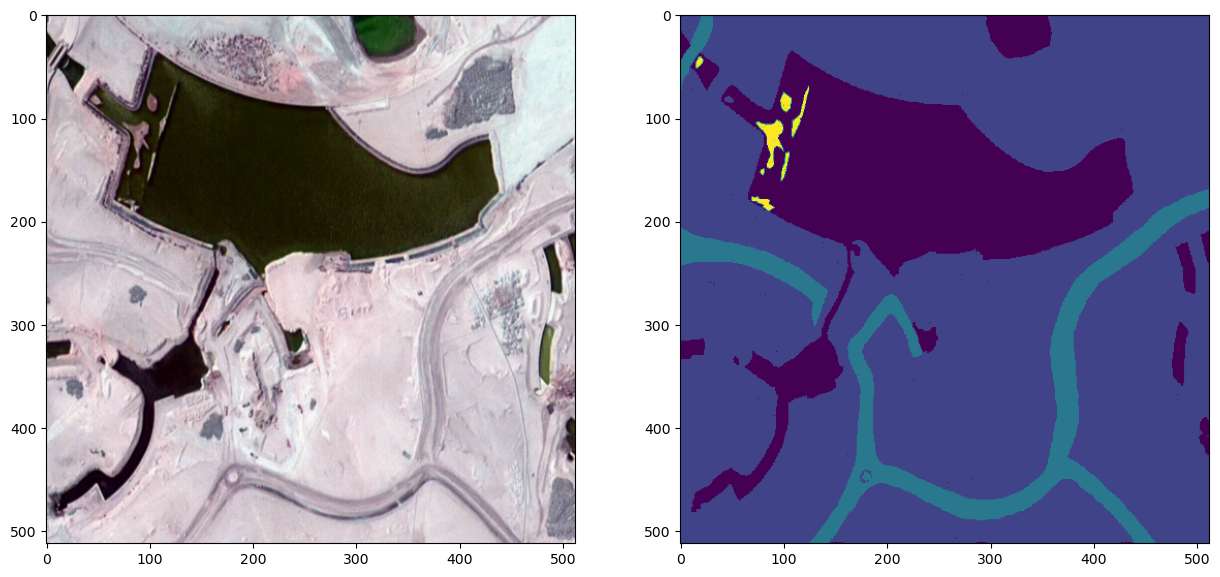

In [5]:
d = dataset[1] ## __getitem__ is called
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [6]:
dataset[1][0].shape

torch.Size([3, 512, 512])

In [7]:

test_num = int(0.1 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=0)

test data : 7


In [8]:
##################################### for GPU ###########################

def get_default_device():
    # pick the gpu if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #move tensors to choosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader():
    # move the batches of the data to our selected device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()

train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

#########################################################################

In [9]:
device

device(type='cuda')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [13]:
criterion = FocalLoss(gamma=3/4).to(device)

In [14]:
def acc(label, predicted):
    seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
    return seg_acc


In [15]:
min_loss = torch.tensor(float('inf'))

model = to_device(UNet(n_channels=3, n_classes=6, bilinear=True),device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [16]:
# model

In [17]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 50
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
plot_acc = []
scheduler_counter = 0

In [18]:
#Total number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

17267718

In [19]:
# SKIP this cell if 


for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):
      pred_mask = model(x)  #[4,6,512,512]
      loss = criterion(pred_mask, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x)  
      val_loss = criterion(pred_mask, y)
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  
  plot_acc.append(np.mean(acc_list))

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/50] [Batch 16/17] [Loss: 1.327701 (1.017824)] epoch 0 - loss : 1.01782 - acc : 0.60 - val loss : 1.00315 - val acc : 0.62
[Epoch 1/50] [Batch 16/17] [Loss: 1.066907 (0.808413)] epoch 1 - loss : 0.80841 - acc : 0.67 - val loss : 0.90039 - val acc : 0.63
[Epoch 2/50] [Batch 16/17] [Loss: 1.120811 (0.752880)] epoch 2 - loss : 0.75288 - acc : 0.68 - val loss : 0.67979 - val acc : 0.70
[Epoch 3/50] [Batch 16/17] [Loss: 1.220132 (0.755512)] epoch 3 - loss : 0.75551 - acc : 0.67 - val loss : 0.78465 - val acc : 0.67
[Epoch 4/50] [Batch 16/17] [Loss: 1.442244 (0.764897)] epoch 4 - loss : 0.76490 - acc : 0.67 - val loss : 0.68500 - val acc : 0.70
[Epoch 5/50] [Batch 16/17] [Loss: 1.548282 (0.757084)] epoch 5 - loss : 0.75708 - acc : 0.66 - val loss : 0.63050 - val acc : 0.72
[Epoch 6/50] [Batch 16/17] [Loss: 0.664691 (0.664725)] epoch 6 - loss : 0.66472 - acc : 0.71 - val loss : 0.65131 - val acc : 0.75
[Epoch 7/50] [Batch 16/17] [Loss: 0.854030 (0.683891)] epoch 7 - loss : 0.68389 - a

In [2]:
#Save loss and accuracy data from training
import json

with open('plot_losses', 'w') as filehandle:
    json.dump(plot_losses, filehandle)

with open('plot_acc', 'w') as filehandle:
    json.dump(plot_acc, filehandle)

NameError: name 'plot_losses' is not defined

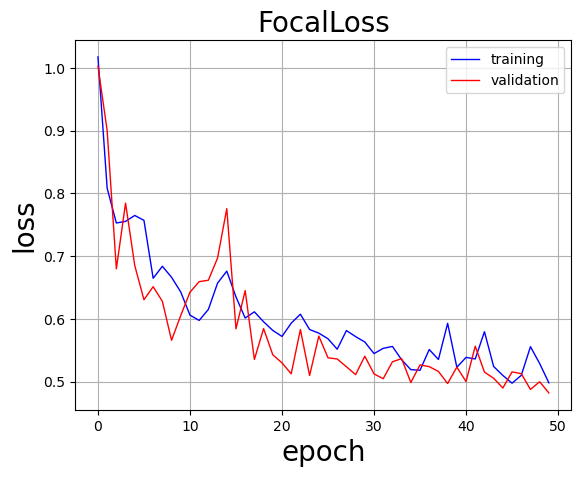

In [21]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=1)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=1)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

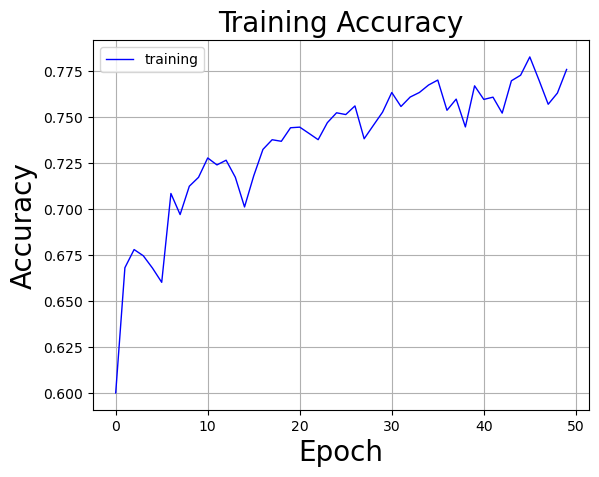

In [22]:
plot_acc = np.array(plot_acc)
plt.plot(plot_acc, color='b', linewidth=1)
#plt.plot(, color='r', linewidth=1)
plt.title('Training Accuracy', fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

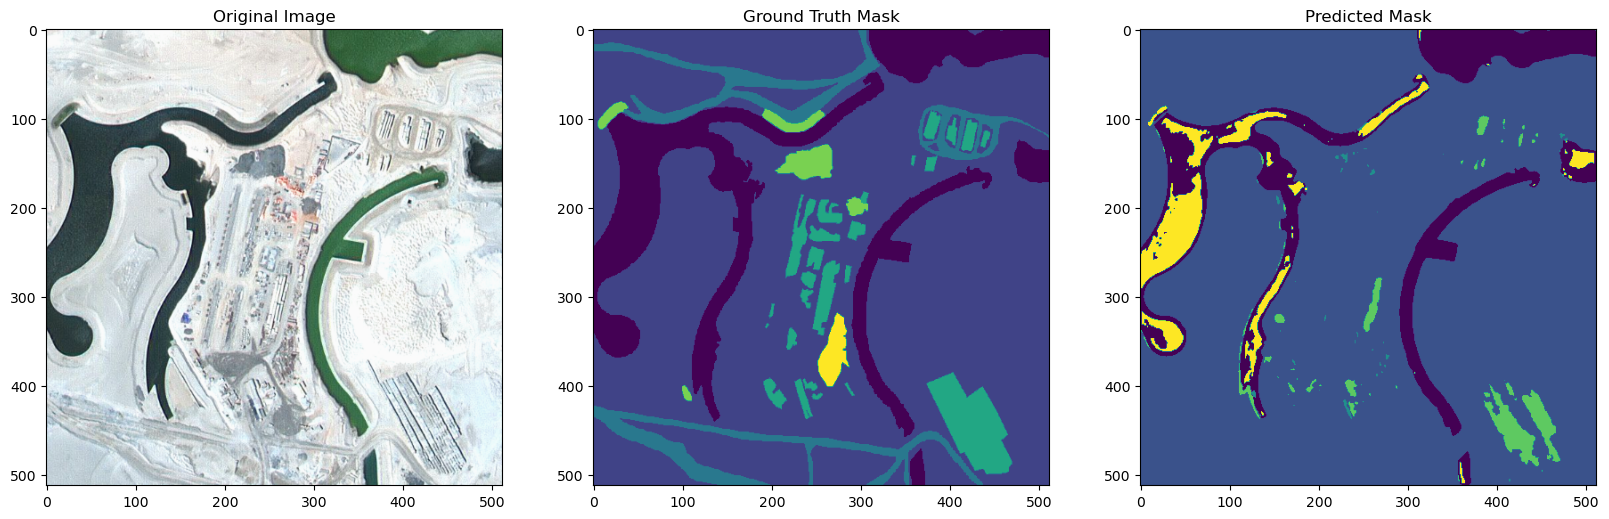

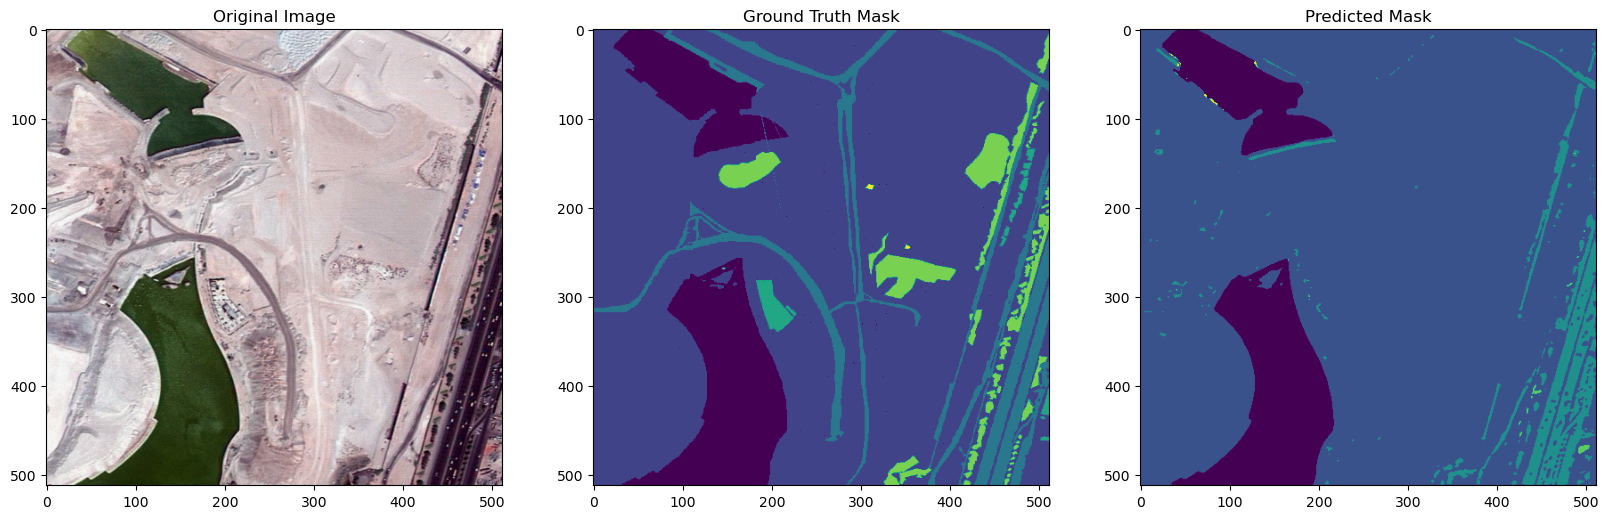

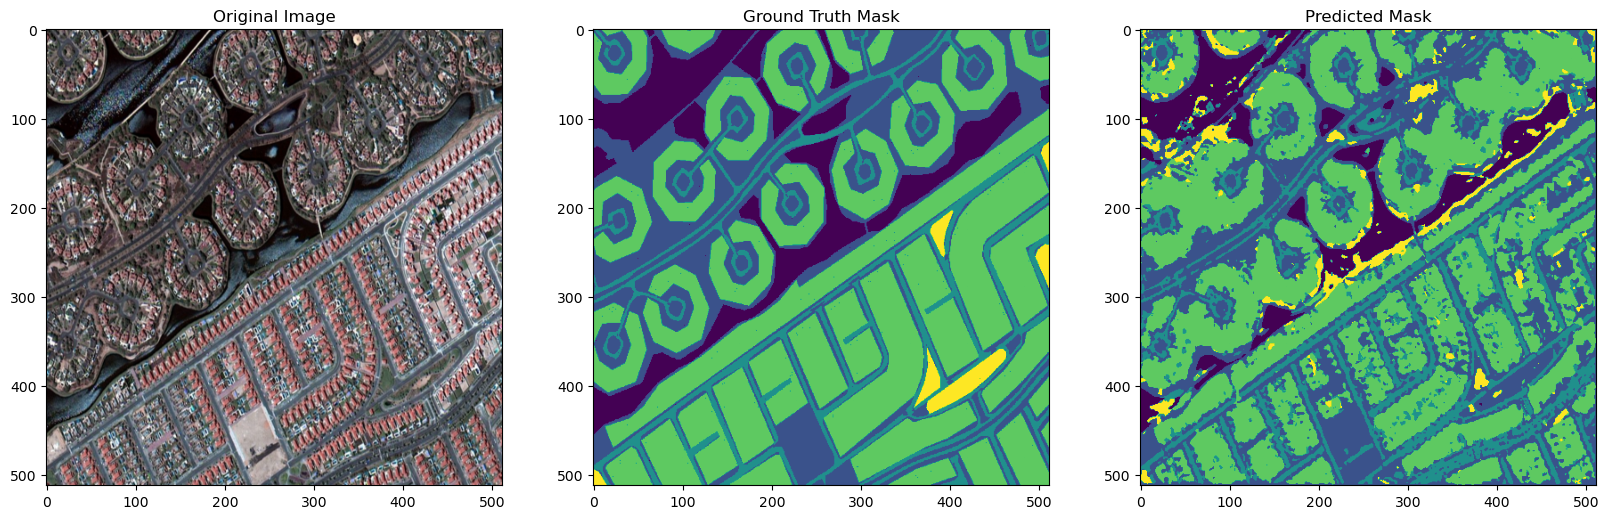

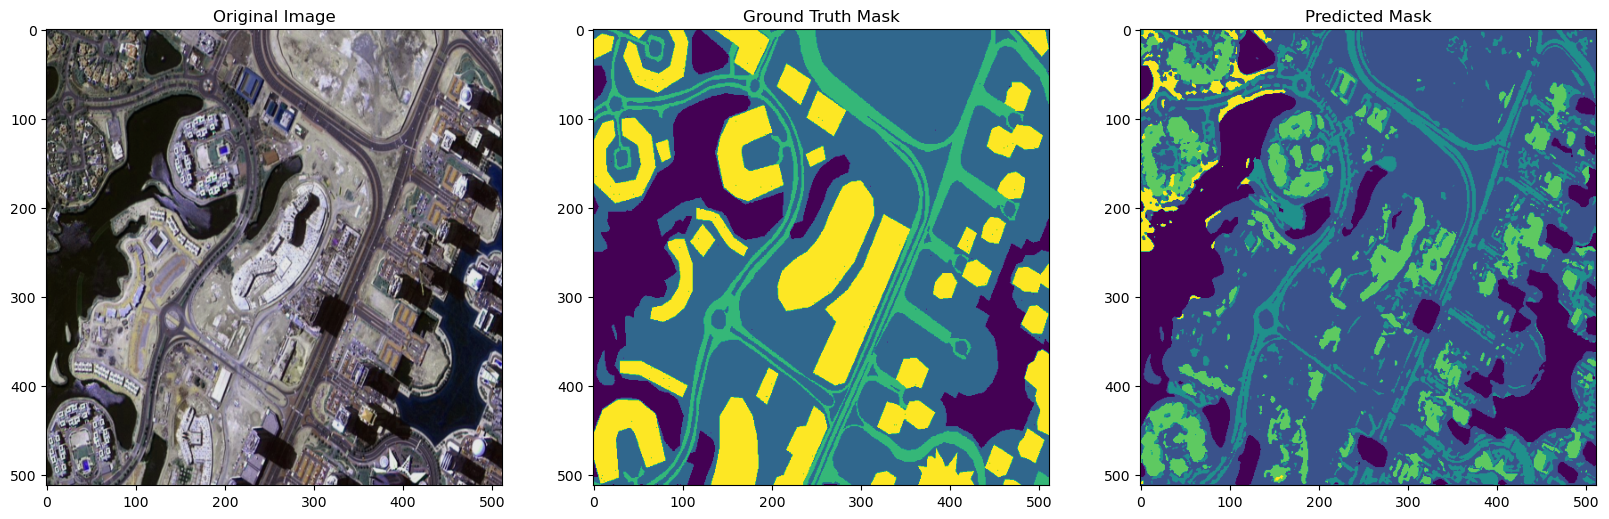

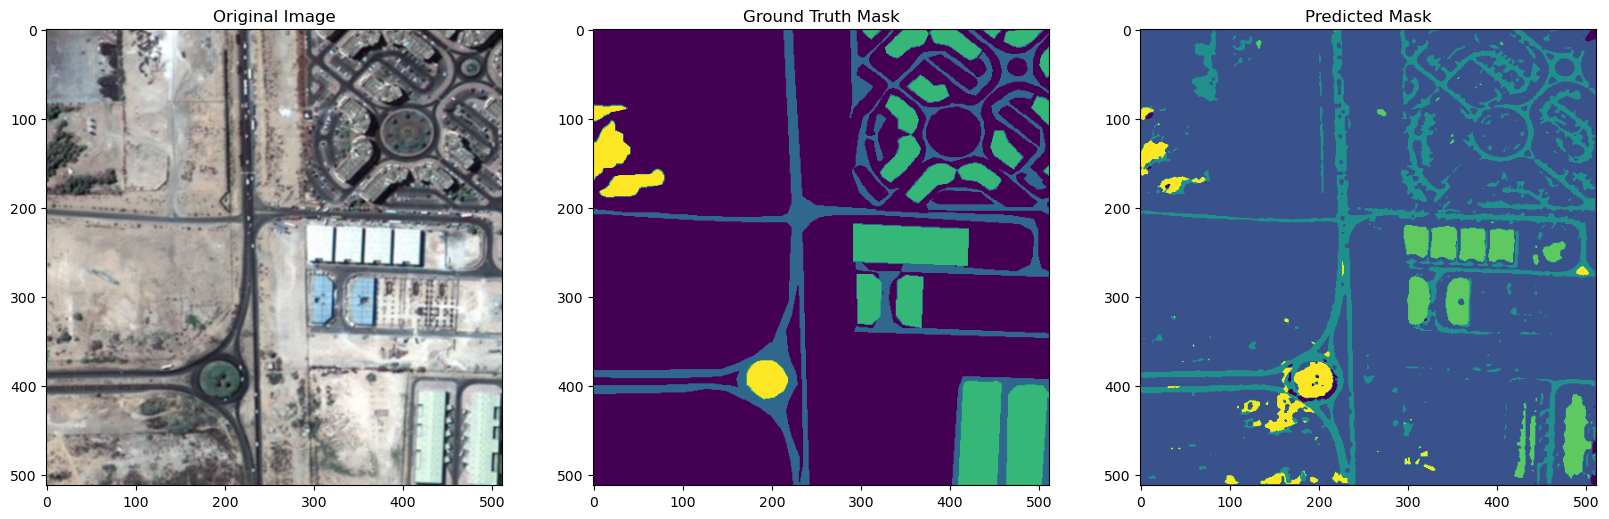

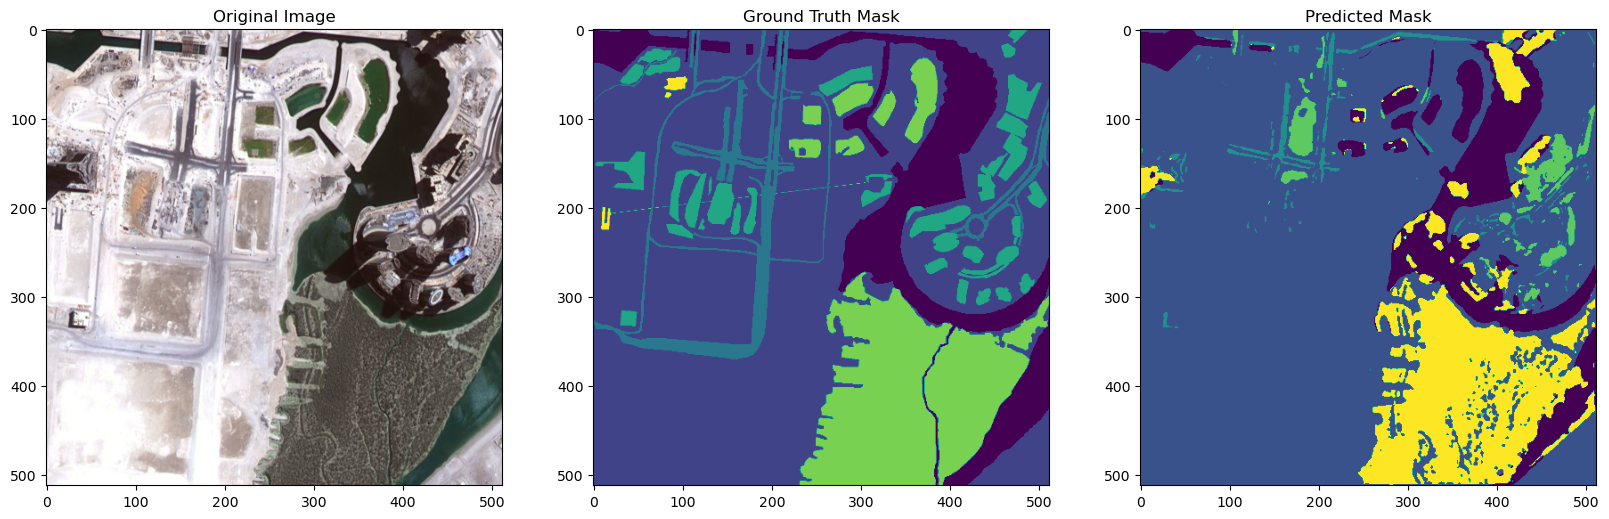

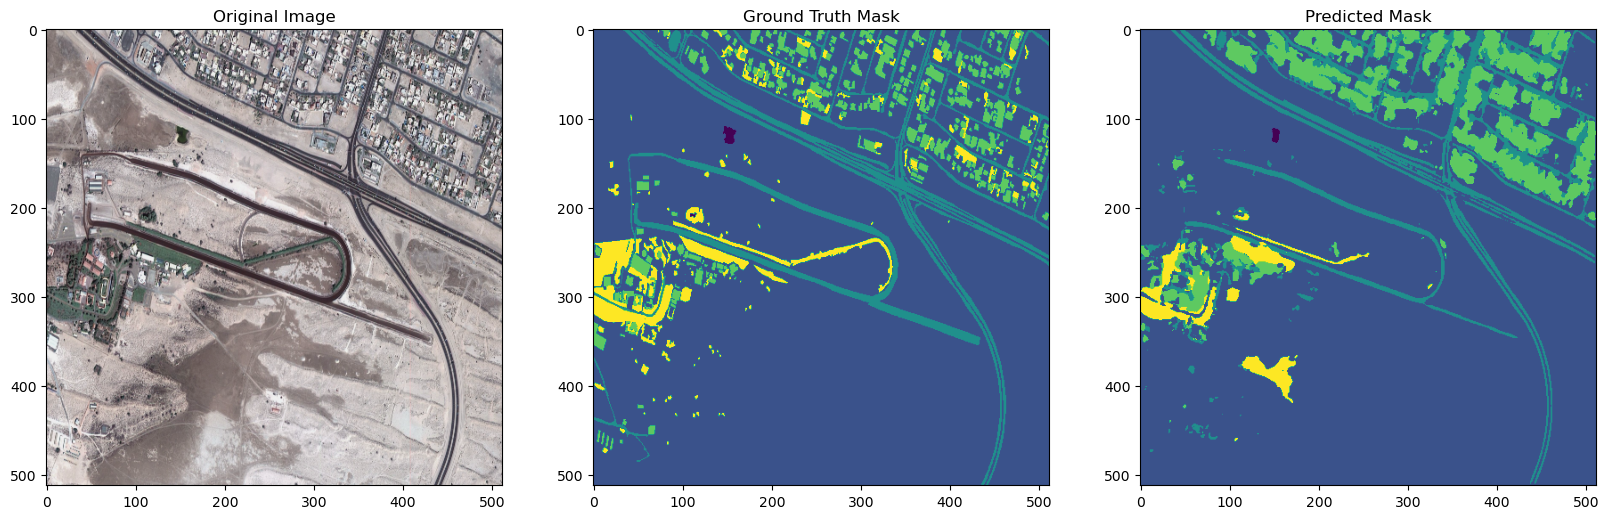

In [23]:
model.eval()
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j].cpu()

        plt.figure(figsize=(20,20))
        
        ax1 = plt.subplot(1,3,1)
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        ax1.title.set_text("Original Image")
        plt.imshow(im)

        ax2 = plt.subplot(1,3,2)
        ax2.title.set_text("Ground Truth Mask")
        plt.imshow(gt_mask)

        ax3 = plt.subplot(1,3,3)
        ax3.title.set_text("Predicted Mask")
        plt.imshow(mask)
        plt.show()

In [24]:
def precision(y, pred_mask, classes = 6):
    precision_list = [];
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

def recall(y, pred_mask, classes = 6):
    recall_list = []
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [25]:
precision_list = []
recall_list = []
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x[j:j+1])
        precision_list.append(precision(y[j],result))
        recall_list.append(recall(y[j],result))

In [26]:
data_precision = np.nanmean(precision_list,axis = 0)
np.nanmean(precision_list,axis = 0)

C:\Users\antho\AppData\Local\Temp\ipykernel_3716\3186963816.py:1: RuntimeWarning: Mean of empty slice
  data_precision = np.nanmean(precision_list,axis = 0)
C:\Users\antho\AppData\Local\Temp\ipykernel_3716\3186963816.py:2: RuntimeWarning: Mean of empty slice
  np.nanmean(precision_list,axis = 0)


array([0.76566039, 0.79874389, 0.49957544, 0.53980807, 0.42656739,
              nan])

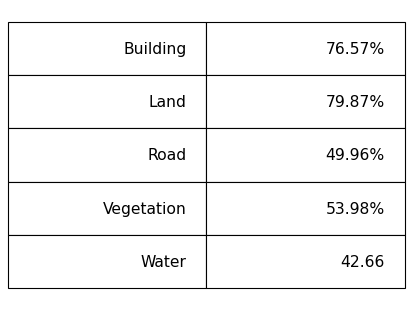

In [27]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ["Building", '{:.02f}%'.format(data_precision[0] * 100)],
    ["Land", '{:.02f}%'.format(data_precision[1] * 100)],
    ["Road", '{:.02f}%'.format(data_precision[2] * 100)],
    ["Vegetation", '{:.02f}%'.format(data_precision[3] * 100)],
    ["Water", '{:.02f}'.format(data_precision[4] * 100)]
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()

In [28]:
data_recall = np.nanmean(recall_list,axis = 0)
np.nanmean(recall_list,axis = 0)

array([0.64507589, 0.86270317, 0.41950603, 0.40766146, 0.31716602,
       0.        ])

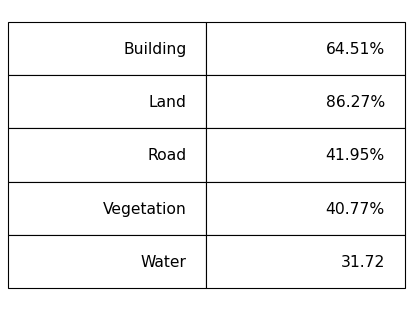

In [29]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ["Building", '{:.02f}%'.format(data_recall[0] * 100)],
    ["Land", '{:.02f}%'.format(data_recall[1] * 100)],
    ["Road", '{:.02f}%'.format(data_recall[2] * 100)],
    ["Vegetation", '{:.02f}%'.format(data_recall[3] * 100)],
    ["Water", '{:.02f}'.format(data_recall[4] * 100)]
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()

In [30]:
final_precision = np.nanmean(precision_list,axis = 0)
sum(final_precision[:-1])/5

C:\Users\antho\AppData\Local\Temp\ipykernel_3716\3563221357.py:1: RuntimeWarning: Mean of empty slice
  final_precision = np.nanmean(precision_list,axis = 0)


0.6060710362557854

In [31]:
final_recall = np.nanmean(recall_list,axis = 0)
sum(final_recall)/5

0.5304225157103724

# Save the model

In [ ]:
torch.save(model.state_dict(),"50epochsUNet")

In [ ]:
model.load_state_dict(torch.load("50epochsUNet"))